## 线性模型
线性假设是指目标（房屋价格）可以表示为特征（面积和房龄）的加权和。线性模型的权重是向量，偏执是标量

 下图是对输入特征的仿射变换：是通过加权和对特征进行线性变换， 并通过偏置项来进行平移
 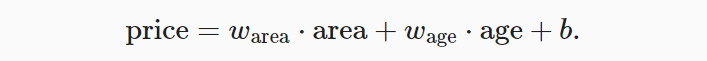

权重决定了每个特征对我们预测值的影响

偏置是指当所有特征都取值为0时，预测值应该为多少。 如果没有偏置项，我们模型的表达能力将受到限制。

## 随机梯度下降
梯度下降算法几乎可以优化所有深度学习模型，它通过计算梯度找到使目标函数值下降最多的方向前进，从而降低了误差

梯度：函数值增加最多的方向。梯度的反方向：函数值下降最多的方向

随机梯度下降的用法：（1）先计算出小批量样本的损失均值（损失函数） （2）再求损失函数对于模型参数的梯度 （3）最后更新参数

模型训练出的参数W,b不会使损失函数真正地达到最小值。 因为算法会使得损失向最小值缓慢收敛，但却不能在有限的步数内非常精确地达到最小值。

## 泛化能力才是评判模型好坏的标准
线性回归恰好是一个在整个域中只有一个最小值的学习问题。 但是对像深度神经网络这样复杂的模型来说，损失平面上通常包含多个最小值。 深度学习实践者很少会去花费大力气寻找这样一组参数，使得在训练集上的损失达到最小。 事实上，更难做到的是找到一组参数，这组参数能够在我们从未见过的数据上实现较低的损失， 这一挑战被称为泛化。

## 矢量加速的必要性
在训练我们的模型时，我们经常希望能够同时处理整个小批量的样本。

In [1]:
%matplotlib inline
import math
import time
import numpy as np
import torch
from d2l import torch as d2l

以两个10000维的向量加法为例，循环对每个维度相加慢得多

In [2]:
n = 10000
a = torch.ones([n])
b = torch.ones([n])
timer = d2l.Timer()
c = torch.zeros(n)
for i in range(n):
    c[i] = a[i] + b[i]
f'{timer.stop():.5f} sec'

'0.08477 sec'

In [3]:
timer.start()
d = a + b
f'{timer.stop():.5f} sec'

'0.00000 sec'

## 正态分布
正态分布和线性回归之间的关系很密切。概率密度函数如下
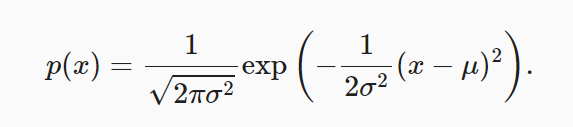

In [4]:
def normal(x, mu, sigma):
    """
    计算正态分布
    mu：均值
    sigma: 标准差
    
    """
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)

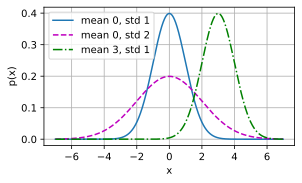

In [5]:
# 再次使用numpy进行可视化
x = np.arange(-7, 7, 0.01)

# 均值和标准差对
params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
         ylabel='p(x)', figsize=(4.5, 2.5),
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

就像我们所看到的，改变均值会产生沿x轴的偏移，增加方差将会分散分布、降低其峰值。

## 线性模型对应的神经网络图
该图只显示连接模式，隐去了权重和偏置的值。
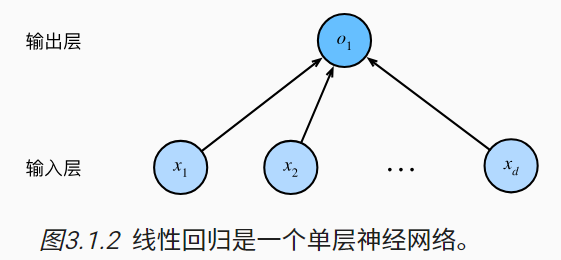

对于线性回归，每个输入都与每个输出相连， 我们将此称为全连接层

### 生成数据集

In [6]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [7]:
def synthetic_data(w, b, num_examples):  
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w))) # 生成训练样本
    y = torch.matmul(X, w) + b  # 生成真实标签
    y += torch.normal(0, 0.01, y.shape) # 增加噪声后作为标签
    return X, y.reshape((-1, 1)) # reshape保证y是二维，自动推导维度0的尺寸

true_w = torch.tensor([2, -3.4]) # 真实的权值值
true_b = 4.2 # 真实的偏置的值

features, labels = synthetic_data(true_w, true_b, 1000) # 获得数据集
features # 1000 x 2

tensor([[-1.5854,  0.6734],
        [-0.9230, -1.1849],
        [-1.0226, -2.6745],
        ...,
        [-1.2399, -2.0336],
        [-0.8985, -0.5744],
        [ 0.3231, -0.6971]])

In [8]:
# 查看一个样本的特征和标签
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([-1.5854,  0.6734]) 
label: tensor([-1.2775])


通过生成第二个特征features[:, 1]和labels的散点图， 可以直观观察到两者之间的线性关系。

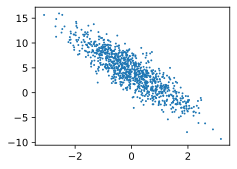

In [9]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

### 读取数据集
训练模型时要对数据集进行遍历，每次抽取一小批量样本，并使用它们来更新我们的模型。 由于这个过程是训练机器学习算法的基础，所以有必要定义一个函数， 该函数能打乱数据集中的样本并以小批量方式获取数据。

In [10]:
# 读取小批量数据样本
def data_iter(batch_size, features, labels):
    num_examples = len(features) # 样本的总数
    indices = list(range(num_examples)) # 生成对应样本数量个索引
    random.shuffle(indices) # 打乱索引顺序，根据乱序的索引取样本
    
    for i in range(0, num_examples, batch_size):
        # 取出batch_size个的乱序的索引
        batch_indices = torch.tensor(indices[i: min(i + batch_size, num_examples)]) 
        yield features[batch_indices], labels[batch_indices] # 返回一批数据

通常，我们利用GPU并行运算的优势，处理合理大小的“小批量”。 每个样本都可以并行地进行模型计算，且每个样本损失函数的梯度也可以被并行计算。 GPU可以在处理几百个样本时，所花费的时间不比处理一个样本时多太多。

### 初始化模型参数w,b
需要对w，b计算梯度，因此需要设置requires_grad=True。w，b作为叶子结点加入计算图中

In [11]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True) # 2x1
b = torch.zeros(1, requires_grad=True)
w, b

(tensor([[-0.0012],
         [ 0.0042]], requires_grad=True),
 tensor([0.], requires_grad=True))

在初始化参数之后，我们的任务是更新这些参数，直到这些参数足够拟合我们的数据。 每次更新都需要计算损失函数关于模型参数的梯度。 有了这个梯度，我们就可以向减小损失的方向更新每个参数。

### 定义模型

In [12]:
def linreg(X, w, b):
    """
    线性回归模型（前向传播的计算很简单）
    """
    return torch.matmul(X, w) + b

### 定义损失函数：回归问题一般的损失一般用均方误差

In [13]:
def squared_loss(y_hat, y): # y_hat是预测值，y是真实值
    """平方误差，torch的实现中没有除2"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2  # 除2是为了求导方便消去2 （未除样本数，此处留到优化算法中除是一样的效果）

### 定义优化算法
小批量随机梯度下降：在每一步中，使用从数据集中随机抽取的一个小批量，然后计算损失函数对模型参数的梯度。接下来，朝着减少损失的方向更新我们的参数。

In [14]:
# def sgd(params, lr, batch_size):
#     """小批量随机梯度下降"""
#     with torch.no_grad():
#         # 下面计算出的tensor不加入计算图
#         for param in params:
#             param -= lr * param.grad / batch_size # 梯度下降（这里除batch_size是为了做均值）
#             param.grad.zero_() # 防止参数w, b累计梯度
            
def sgd(params, lr):
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad# 梯度下降
            param.grad.zero_() # 防止参数w, b累计梯度

### 训练

In [15]:
lr = 0.03 # 学习率
num_epochs = 3 # 迭代周期总数
net = linreg 
loss = squared_loss
batch_size = 10

# for epoch in range(num_epochs):
#     for X, y in data_iter(batch_size, features, labels):
#         l = loss(net(X, w, b), y) # 小批量的损失
#         # 计算梯度之前需要梯度清零，不然会累计梯度导致参数变化的不准了
#         if w.grad is not None:
#             w.grad.data.zero_()
#         if b.grad is not None:
#             b.grad.data.zero_()
#         # 因为l形状是(batch_size,1)，而不是一个标量。将l中的所有元素被加到一起，并以此计算关于[w,b]的梯度
#         # 计算梯度（这里的损失函数没有求均值，因为用的l.sum()而不是l.mean()，因此需要在更新参数的时候除样本数）
#         l.sum().backward() 
#         # 梯度将用在更新参数的公式中
#         sgd([w, b], lr, batch_size) # 更新参数
        
#     with torch.no_grad():
#         train_l = loss(net(features, w, b), labels) # 参数一次epoch后，在整个数据集上的损失
#         print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y) # 小批量的损失
        if w.grad is not None:
            w.grad.data.zero_()
        if b.grad is not None:
            b.grad.data.zero_()
        # 因为l形状是(batch_size,1)，而不是一个标量。将l中的所有元素被加到一起，并以此计算关于[w,b]的梯度
        # 计算梯度（这里的损失函数没有求均值，因为用的l.sum()而不是l.mean()，因此需要在更新参数的时候除样本数）
        l.mean().backward() 
        # 梯度将用在更新参数的公式中
        sgd([w, b], lr) # 更新参数
        
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels) # 参数一次epoch后，在整个数据集上的损失
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.035526
epoch 2, loss 0.000128
epoch 3, loss 0.000051


In [16]:
# 可见误差非常小
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([3.5763e-06, 8.1778e-05], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0006], grad_fn=<RsubBackward1>)


In [17]:
w, b

(tensor([[ 2.0000],
         [-3.4001]], requires_grad=True),
 tensor([4.1994], requires_grad=True))

In [18]:
true_w, true_b

(tensor([ 2.0000, -3.4000]), 4.2)